## setwd

In [7]:
setwd('D:/Work/mgh/covid19')
source('E:/iHuman/src/GPMM_local/subroutines.R')
library(pheatmap)
#library(DESeq2)
#library(edgeR)
library(ggsci)
library(pracma)
library(ggplot2)
library(EnhancedVolcano)
library(ggvenn)
library(reshape2)
library(ggsci)

## read data

In [6]:
flux3 = file2frame('D:/Work/mgh/covid19/modeling/v20200530_cellpaper/out/PQMM_fluxRxnsMean.txt',row.names = 1)
flux3.annote = file2frame('D:/Work/mgh/covid19/modeling/v20200530_cellpaper/out/Recon3_covid19_rxns_geneSymbol_20200530v1.txt',row.names = 1)
clin = file2frame('D:/Work/mgh/covid19/modeling/v20200530_cellpaper/out/sraRunTable_metadata_valid_human.txt',row.names = 1)
covid_load = file2frame('D:/Work/mgh/covid19/data/COVID_Transcriptome_CELL_2020/virus_counts_perc.txt',row.names =1)
id = !duplicated(clin$GEO_Accession..exp.)
clin = clin[id,]
rownames(clin)  = clin$GEO_Accession..exp.
fluxnames = gsub('P|C','',colnames(flux3))
list[IA,IB] = ismember(rownames(clin),fluxnames)
clin = clin[IA,]
flux3 = flux3[,IB]
clin$is_infect = substr(colnames(flux3),1,1)
colnames(flux3) = gsub('P|C','',colnames(flux3))
# valid flux3 reaction
idxx = rowMeans(abs(flux3))> 1e-6
flux3 = flux3[idxx,]
flux3.log2= as.matrix(log2(abs(flux3)+1e-6))
list[IA,IB] = ismember(rownames(flux3.log2),rownames(flux3.annote))
flux3.annote = flux3.annote[IB,]


covid_load = file2frame('D:/Work/mgh/covid19/data/COVID_Transcriptome_CELL_2020/virus_counts_perc.txt',row.names =1)
covid_load = covid_load[,colnames(flux3)]
the_load = unlist(colSums(covid_load))
the_load[is.na(the_load)] = 0
clin$covid_load  = the_load
bx = unique(clin$source_name)
bx = factor(clin$source_name,levels = unique(clin$source_name),labels = c('NHBE','NHBE_infect(IAV)','NHBE_infect(IAVdNS1)','NHBE_IFNB',
                                                           'A549','A549_infect(Covid19)','A549_ACE2',
                                                           'Lung_biopsy','Lung_biopsy_infect(Covid19)','A549_ACE2_infect(Covid19)',
                                                           'Calu3','Calu3_infect(Covid19)','A549_infect(RSV)','A549_infect(HPIV3)',
                                                           'NHBE_infect(Covid19)','A549_infect(IAV)'))
clin$source_name1 = as.vector(bx)


In [7]:
clin$source_name1 = factor(clin$source_name1,levels = c('A549','A549_infect(Covid19)','A549_ACE2','A549_ACE2_infect(Covid19)',
                                                        'Calu3','Calu3_infect(Covid19)','NHBE','NHBE_infect(Covid19)',
                                                         'Lung_biopsy','Lung_biopsy_infect(Covid19)',
                                                          'NHBE_infect(IAV)','NHBE_infect(IAVdNS1)','NHBE_IFNB',
                                                           'A549_infect(RSV)','A549_infect(HPIV3)',
                                                           'A549_infect(IAV)'))

## Figure 2A viral load

In [348]:
biomass_elife_addlipid = file2frame('D:/Work/mgh/covid19/modeling/v20200530_cellpaper/out_biomass_flux/covid10_biomass_clin_20200526_elife_biomass_add_lipid.txt')
id = !is.na(biomass_elife_addlipid$class)
tmp = biomass_elife_addlipid[id,]
tmp$source_name1 = factor(tmp$source_name1,levels = c('A549', 'A549_infect(Covid19)', 
                      'A549_ACE2','A549_ACE2_infect(Covid19)', 'Lung_biopsy', 'Lung_biopsy_infect(Covid19)',
                      'Calu3', 'Calu3_infect(Covid19)', 'NHBE', 'NHBE_infect(Covid19)'))
ida = tmp$covid_load > 1e-5 & 
        tmp$source_name1 != 'NHBE' & tmp$source_name1 != 'NHBE_infect(Covid19)' &
        tmp$source_name1 != 'Calu3' & tmp$source_name1 != 'Calu3_infect(Covid19)'
pdf('D:/Work/mgh/covid19/modeling/v20200530_cellpaper/figures/Figure 2A_biomass_covid19_load_prediction_v20220521.pdf',width = 5,height = 4)         
ggplot(tmp[ida,],aes(log10(biomass_covid19),log10(covid_load))) +
 geom_point(size = 6)+ theme_classic() + lghplot.addtheme(legend.position = 'right',size = 16)+
geom_smooth(se = T, method = "gam", formula = y~x )+
annotate(geom="text", x=-4.5, y=1, parse = TRUE,
               label = expression(atop(paste(italic(r),' = 0.75'),
                                      paste(italic(P), '= 0.003'))),
         color="darkblue",size = 10)+xlab('Log10(biomass_SARS-CoV-2)')+ ylab('Log10(viral_load)')
         
dev.off()
cor.test(log10(tmp$biomass_covid19[ida]),log10(tmp$covid_load[ida]))

Warning message in is.na(x):
"is.na()不适用于类别为'expression'的非串列或非矢量"

png 
  2


	Pearson's product-moment correlation

data:  log10(tmp$biomass_covid19[ida]) and log10(tmp$covid_load[ida])
t = 3.7447, df = 11, p-value = 0.00324
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3363480 0.9200817
sample estimates:
      cor 
0.7486005 


## Figure 2B pathway analysis

### A549

In [11]:
#'A549'
id = clin$source_name == 'Mock treated A549 cells trasnduced with a vector expressing human ACE2' |
      clin$source_name == 'SARS-CoV-2 infected A549 cells trasnduced with a vector expressing human ACE2'
flux3.log2.A549 = flux3.log2[,id]
flux3.A549 = flux3[,id]
clin.A549 = clin[id,]

In [12]:
theservePathway = c('SARS-Cov-2 proteins','SARS-Cov-2 sense RNA',
                   'SARS-Cov-2 antisense RNA','SARS-Cov-2 lipid',
                   'SARS-Cov-2 cleavage','SARS-Cov-2 biomass')
WDA.covid.A549 = one_line_flux_analysis(flux3.A549,flux3.log2.A549[,clin.A549$is_infect == 'P'],flux3.log2.A549[,clin.A549$is_infect == 'C'],
                                               flux3.annote,'./modeling/v20200530_cellpaper/results/oneline_flux_A549ACE2_v20230209',
                                        reserve.pathway = theservePathway)

[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   117"
[1] "N down-regulated rxns: 510"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"


In [18]:
DEflux3.A549 = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_A549ACE2_v20230209/DEflux.txt')
rownames(DEflux3.A549) = DEflux3.A549$ID

### Calu3

In [14]:
id = clin$source_name == 'Mock treated Calu-3 cells' |
      clin$source_name == 'SARS-CoV-2 infected Calu-3 cells'
flux3.log2.Calu3 = flux3.log2[,id]
flux3.Calu3 = flux3[,id]
clin.Calu3 = clin[id,]
theservePathway = c('SARS-Cov-2 proteins','SARS-Cov-2 sense RNA',
                   'SARS-Cov-2 antisense RNA','SARS-Cov-2 lipid',
                   'SARS-Cov-2 cleavage','SARS-Cov-2 biomass')
WDA.covid.Calu3 = one_line_flux_analysis(flux3.Calu3,flux3.log2.Calu3[,clin.Calu3$is_infect == 'P'],flux3.log2.Calu3[,clin.Calu3$is_infect == 'C'],
                                               flux3.annote,'./modeling/v20200530_cellpaper/results/oneline_flux_Calu3_v20230209',
                                           reserve.pathway = theservePathway)

[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   218"
[1] "N down-regulated rxns: 209"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"


In [16]:
DEflux3.Calu3 = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_Calu3_v20230209/DEflux.txt')
rownames(DEflux3.Calu3) = DEflux3.Calu3$ID

### NHBE

In [15]:
id = (clin$source_name == 'Mock treated NHBE cells' |
      clin$source_name == 'SARS-CoV-2 infected NHBE cells') & clin$time_point =='24hrs after treatment'
flux3.log2.NHBE  = flux3.log2[,id]
flux3.NHBE  = flux3[,id]
clin.NHBE  = clin[id,]
theservePathway = c('SARS-Cov-2 proteins','SARS-Cov-2 sense RNA',
                   'SARS-Cov-2 antisense RNA','SARS-Cov-2 lipid',
                   'SARS-Cov-2 cleavage','SARS-Cov-2 biomass')
WDA.covid.NHBE = one_line_flux_analysis(flux3.NHBE,flux3.log2.NHBE[,clin.NHBE$is_infect == 'P'],flux3.log2.NHBE[,clin.NHBE$is_infect == 'C'],
                                               flux3.annote,'./modeling/v20200530_cellpaper/results/oneline_flux_NHBE_v20230209',
                                       reserve.pathway = theservePathway)


[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   127"
[1] "N down-regulated rxns: 194"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"


In [17]:
DEflux3.NHBE = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_NHBE_v20230209/DEflux.txt')
rownames(DEflux3.NHBE) = DEflux3.NHBE$ID

### Figure 2B heatmap

In [83]:
    DE1 = WDA.covid.A549[WDA.covid.A549$fdr < 0.1,]
    DE2 = WDA.covid.Calu3[WDA.covid.Calu3$fdr < 0.1,]
    DE3 = WDA.covid.NHBE[WDA.covid.NHBE$fdr < 0.1,]
    rownames(DE1) = DE1$subsystem
    rownames(DE2) = DE2$subsystem
    rownames(DE3) = DE3$subsystem
    #DE1$DAscore[DE1$fdr > 0.05 ] = NA
    #DE2$DAscore[DE2$fdr > 0.05 ] = NA
    #DE3$DAscore[DE3$fdr > 0.1 ] = NA
    celltypes = c('A549ACE2','Calu3','NHBE')
    tlist1 = list()
    tlist1[[1]] = as.data.frame(t(DE1$DAscore))
    colnames(tlist1[[1]]) = DE1$subsystem
    tlist1[[2]] = as.data.frame(t(DE2$DAscore))
    colnames(tlist1[[2]]) = DE2$subsystem
    tlist1[[3]] = as.data.frame(t(DE3$DAscore))
    colnames(tlist1[[3]]) = DE3$subsystem
    names(tlist1) = celltypes
    tmpmatrix = t(data.table::rbindlist(tlist1,fill = T))
    colnames(tmpmatrix) = celltypes
    tmpmatrix[is.na(tmpmatrix)] =0
    
    tlist2 = list()
    tlist2[[1]] = as.data.frame(t(DE1$fdr))
    colnames(tlist2[[1]]) = DE1$subsystem
    tlist2[[2]] = as.data.frame(t(DE2$fdr))
    colnames(tlist2[[2]]) = DE2$subsystem
    tlist2[[3]] = as.data.frame(t(DE3$fdr))
    colnames(tlist2[[3]]) = DE3$subsystem
    names(tlist2) =celltypes
    tmpmatrix2 = t(data.table::rbindlist(tlist2,fill = T))
    colnames(tmpmatrix2) = celltypes
    tmpmatrix2[is.na(tmpmatrix2)] =1
    
    display_matrix = matrix(' ',nrow(tmpmatrix),ncol(tmpmatrix))
    display_matrix[tmpmatrix2 < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix[tmpmatrix2 >= 0.01 & tmpmatrix2 < 0.05] = '*'
    display_matrix[tmpmatrix2 >= 0.001 & tmpmatrix2 < 0.01] = '**'
    display_matrix[tmpmatrix2 < 0.001] = '***'
    
    enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
    consist_ids = abs(rowSums(sign(tmpmatrix))) > 1  
    pheatmap::pheatmap(tmpmatrix[consist_ids,],scale = 'none',cluster_rows = T,fontsize_row = 9,fontsize_col = 9,
                       breaks = enbrks,
                       treeheight_row = 20,treeheight_col = 20,legend = T,
                       display_numbers = display_matrix[consist_ids,],
                  #color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(9),
                       #colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                       color=colorRampPalette(c('#4DBBD599','gray95','#E64B3599'))(11),#npg style
                #color=colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                  #file ='./modeling/v20200530_cellpaper/figures/Figure 2B_pathwayheatmap.pdf',
                  file ='./modeling/v20200530_cellpaper/figures/Figure 2B_pathwayheatmap_consist_v20230209AA.pdf',
                  ,height = 5,width = 4.3)

## Gene Knockout Table S1-S3

In [142]:
# The result of Gene Knockout analysis are perferming in matlab using the following commond:
#   Gene_KO_analysis_v20221010
# This section just to refine the result

### A549 Table S1

In [16]:
komatrix = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOgene_A549ACE2_effectMatrix.txt')
#colnames(komatrix) = gsub('.e.','(e)',colnames(komatrix))
komatrix.num = as.matrix(komatrix[,-1])
id = rowSums(abs(komatrix.num)) > 0
komatrix = komatrix[id,]
dim(komatrix)
writetxt(komatrix,'D:/Work/mgh/covid19/modeling/v20200530_cellpaper/Figures/Table S1_geneko_effect_A549ace2_add_direct.txt')


[1] 181 214

### Calu3 Table S2

In [18]:
komatrix = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOgene_Calu3_effectMatrix.txt')
#colnames(komatrix) = gsub('.e.','(e)',colnames(komatrix))
komatrix.num = as.matrix(komatrix[,-1])
id = rowSums(abs(komatrix.num)) > 0
komatrix = komatrix[id,]
dim(komatrix)
writetxt(komatrix,'D:/Work/mgh/covid19/modeling/v20200530_cellpaper/Figures/Table S2_geneko_effect_Calu3_add_direct.txt')


[1] 166 229

### NHBE Table S3

In [20]:
komatrix = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOgene_NHBE_effectMatrix.txt')
#colnames(komatrix) = gsub('.e.','(e)',colnames(komatrix))
komatrix.num = as.matrix(komatrix[,-1])
id = rowSums(abs(komatrix.num)) > 0
komatrix = komatrix[id,]
dim(komatrix)
writetxt(komatrix,'D:/Work/mgh/covid19/modeling/v20200530_cellpaper/Figures/Table S3_geneko_effect_NHBE_add_direct.txt')


[1] 171 155

## Metabolite Knockout: Table S4-S6

In [159]:
# The result of Gene Knockout analysis are perferming in matlab using the following commond:
#   GeneMetabolite_KO_analysis_v20221010
# This section just to refine the result

### A549 Table S4

In [49]:
komatrix = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOmet_A549ACE2_effectMatrix.txt')
#colnames(komatrix) = gsub('.e.','(e)',colnames(komatrix))
komatrix.num = as.matrix(komatrix[,-1])
id = rowSums(abs(komatrix.num)) > 0
komatrix = komatrix[id,]
dim(komatrix)
writetxt(komatrix,'D:/Work/mgh/covid19/modeling/v20200530_cellpaper/Figures/Table S4_metko_effect_A549ace2_add_direct.txt')


[1] 462 214

### Calu3  Table S5

In [50]:
komatrix = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOmet_Calu3_effectMatrix.txt')
#colnames(komatrix) = gsub('.e.','(e)',colnames(komatrix))
komatrix.num = as.matrix(komatrix[,-1])
id = rowSums(abs(komatrix.num)) > 0
komatrix = komatrix[id,]
dim(komatrix)
writetxt(komatrix,'D:/Work/mgh/covid19/modeling/v20200530_cellpaper/Figures/Table S5_metko_effect_Calu3_add_direct.txt')


[1] 455 229

### NHBE  Table S6

In [51]:
komatrix = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOmet_NHBE_effectMatrix.txt')
#colnames(komatrix) = gsub('.e.','(e)',colnames(komatrix))
komatrix.num = as.matrix(komatrix[,-1])
id = rowSums(abs(komatrix.num)) > 0
komatrix = komatrix[id,]
dim(komatrix)
writetxt(komatrix,'D:/Work/mgh/covid19/modeling/v20200530_cellpaper/Figures/Table S6_metko_effect_CNHBE_add_direct.txt')

[1] 400 155

## Overlaped targets and nutrition

### Overlaped targets(genes)

In [41]:
cutoff = 3

a549 = file2frame('./modeling/v20200530_cellpaper/results/v20221207/KOgene_A549ACE2_KO_effect_genes.txt')
Calu3 = file2frame('./modeling/v20200530_cellpaper/results/v20221207/KOgene_Calu3_KO_effect_genes.txt')
NHBE = file2frame('./modeling/v20200530_cellpaper/results/v20221207/KOgene_NHBE_KO_effect_genes.txt')

overlap.up = intersect(a549$gene[a549$effect_GeneKO >= cutoff],Calu3$gene[Calu3$effect_GeneKO >= cutoff])
overlap.up = intersect(overlap.up,NHBE$gene[NHBE$effect_GeneKO >= cutoff])
overlap.up = unique(overlap.up)
overlap.up



overlap.down = intersect(a549$gene[a549$effect_GeneKO <= -cutoff],Calu3$gene[Calu3$effect_GeneKO <= -cutoff])
overlap.down = intersect(overlap.down,NHBE$gene[NHBE$effect_GeneKO <= -cutoff])
overlap.down = unique(overlap.down)
overlap.down

get_subterm_gene <- function(df, genes){
    out = df[is.element(df$gene,genes),]
    out = out[abs(out$effect_GeneKO) > 0,]
    rownames(out) = out$gene
    
    return(out)
}

tmp = c(overlap.up,overlap.down)
a549.overlap = get_subterm_gene(a549,tmp)
Calu3.overlap = get_subterm_gene(Calu3,tmp)
NHBE.overlap = get_subterm_gene(NHBE,tmp)
Overlaped_target_3celllines = data.frame(Target = tmp, stringsAsFactors = F,
                              Action = c(rep('agonist',length(overlap.up)),rep('antagonist',length(overlap.down))),
                              effect_GeneKO_A549ACE2 = a549.overlap[tmp,]$effect_GeneKO,
                              effect_GeneKO_Calu3 = Calu3.overlap[tmp,]$effect_GeneKO,
                              effect_GeneKO_NHBE = NHBE.overlap[tmp,]$effect_GeneKO)
Overlaped_target_3celllines
#writetxt(Overlaped_target_3celllines,'./modeling/v20200530_cellpaper/Figures/Table S7_Overlaped_target_3celllines.txt')

[1] "TYMS" "DHFR"

[1] "PAICS" "GART"  "ATIC"  "PPAT"  "PFAS"

Target,Action,effect_GeneKO_A549ACE2,effect_GeneKO_Calu3,effect_GeneKO_NHBE
<chr>,<chr>,<dbl>,<dbl>,<dbl>
TYMS,agonist,8.26588,3.00000,8.59583
DHFR,agonist,9.26588,4.00000,8.59583
PAICS,antagonist,-3.32763,-8.64075,-5.21016
GART,antagonist,-3.32763,-8.64075,-5.21016
ATIC,antagonist,-3.32763,-8.64075,-5.21016
PPAT,antagonist,-3.32763,-8.64075,-5.21016
PFAS,antagonist,-3.32763,-8.64075,-5.21016


### overlaped targets(genes)-biomass_only

In [55]:
komatrix.a549 = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOgene_A549ACE2_effectMatrix.txt')
viral_component =c('YP_009724390', 'YP_009724392', 'YP_009724393', 'YP_009724397',
                   'COVID_RNA_BS_pos', 'COVID_RNA_BS_neg', 'COVID_lipids', 'biomass_reaction')
ids = is.element(komatrix.a549$gene,Overlaped_target_3celllines$Target)
kogene_viral.a549 = komatrix.a549[ids,c('gene',viral_component)]

#calu3
komatrix.Calu3 = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOgene_Calu3_effectMatrix.txt')
ids = is.element(komatrix.Calu3$gene,Overlaped_target_3celllines$Target)
kogene_viral.Calu3 = komatrix.Calu3[ids,c('gene',viral_component)]

#NHBE
komatrix.NHBE = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOgene_NHBE_effectMatrix.txt')
ids = is.element(komatrix.NHBE$gene,Overlaped_target_3celllines$Target)
kogene_viral.NHBE = komatrix.NHBE[ids,c('gene',viral_component)]

tmp = rbind(rbind(kogene_viral.a549,kogene_viral.Calu3),kogene_viral.NHBE)

kogene_viral = cbind(data.frame(Celltype = c(rep('A549ACE2',nrow(kogene_viral.a549)),
                                            rep('Calu3',nrow(kogene_viral.Calu3)),
                                             rep('NHBE',nrow(kogene_viral.NHBE)))),tmp)
writetxt(kogene_viral,'./modeling/v20200530_cellpaper/Figures/Table S_geneKO_viral_biomass_3celllines.txt')

### Overlaped metabolites

In [42]:
get_consist_mets <- function(ma,cutoff){
    tmpout = ma
    tmpout$direct = sign(tmpout$Effect_afterKO)* (abs(tmpout$Effect_afterKO) >= cutoff)
    tmpout$met_name = substr(tmpout$metid,1,nchar(tmpout$metid)-3)
    uname = unique(tmpout$met_name[tmpout$direct != 0])
    tmpout$direct.v = tmpout$direct
    for(i in 1:length(uname)){
        tmpids = which(tmpout$met_name == uname[i])
        if(any(tmpout$direct[tmpids] > 0) & any(tmpout$direct[tmpids] < 0)){
            tmpout$direct.v[tmpids] = 0
        }
    }
    return(tmpout)
}

In [43]:
cutoff = 3
a549 = file2frame('./modeling/v20200530_cellpaper/results/v20221207/KOmet_A549ACE2_KO_effect_mets.txt')
Calu3 = file2frame('./modeling/v20200530_cellpaper/results/v20221207/KOmet_Calu3_KO_effect_mets.txt')
NHBE = file2frame('./modeling/v20200530_cellpaper/results/v20221207/KOmet_NHBE_KO_effect_mets.txt')

#get consense 
a549 = get_consist_mets(a549,cutoff)
Calu3 = get_consist_mets(Calu3,cutoff)
NHBE = get_consist_mets(NHBE,cutoff)

overlap.up = intersect(a549$metid[a549$direct.v >= 1],Calu3$metid[Calu3$direct.v >= 1])
overlap.up = intersect(overlap.up,NHBE$metid[NHBE$direct.v >= 1])
overlap.up = unique(overlap.up)
overlap.up



overlap.down = intersect(a549$metid[a549$direct.v <= -1],Calu3$metid[Calu3$direct.v <= -1])
overlap.down = intersect(overlap.down,NHBE$metid[NHBE$direct.v <= -1])
overlap.down = unique(overlap.down)
overlap.down
# remove covid component
set_covid_component = c('YP_009724390[c]', 'YP_009724392[c]', 'YP_009724393[c]', 'YP_009724397[c]',
                        'COVID_RNA_BS_pos[c]', 'COVID_RNA_BS_neg[c]')
overlap.down = setdiff(overlap.down,set_covid_component)

get_subterm_met <- function(df, mets){
    out = df[is.element(df$metid,mets),]
    out = out[abs(out$Effect_afterKO) > 0,]
    rownames(out) = out$metid
    
    return(out)
}

tmp = c(overlap.up,overlap.down)
a549.overlap = get_subterm_met(a549,tmp)
Calu3.overlap = get_subterm_met(Calu3,tmp)
NHBE.overlap = get_subterm_met(NHBE,tmp)
Overlaped_metabolites_3celllines = data.frame(Metabolites = tmp, stringsAsFactors = F,
                              Action = c(rep('agonist',length(overlap.up)),rep('antagonist',length(overlap.down))),
                              effect_MetKO_A549ACE2 = a549.overlap[tmp,]$Effect_afterKO,
                              effect_MetKO_Calu3 = Calu3.overlap[tmp,]$Effect_afterKO,
                              effect_MetKO_NHBE = NHBE.overlap[tmp,]$Effect_afterKO)
Overlaped_metabolites_3celllines = cbind(Overlaped_metabolites_3celllines,a549.overlap[tmp,-c(1,2)])
Overlaped_metabolites_3celllines
#writetxt(Overlaped_metabolites_3celllines,'./modeling/v20200530_cellpaper/Figures/Table S8_Overlaped_metabolites_3celllines.txt')

[1] "mlthf[c]" "akg[c]"

[1] "gly[c]"              "gtp[c]"              "dcamp[c]"           
 [4] "cys_L[c]"            "imp[c]"              "YP_009724390[c]"    
 [7] "YP_009724392[c]"     "YP_009724393[c]"     "YP_009724397[c]"    
[10] "COVID_RNA_BS_pos[c]" "COVID_RNA_BS_neg[c]" "phe_L[c]"           
[13] "asn_L[c]"            "lys_L[c]"            "arg_L[c]"           
[16] "met_L[c]"            "thr_L[c]"            "25aics[c]"          
[19] "air[c]"              "5aizc[c]"            "gar[c]"             
[22] "fgam[c]"             "pram[c]"             "fpram[c]"

,Metabolites,Action,effect_MetKO_A549ACE2,effect_MetKO_Calu3,effect_MetKO_NHBE,metname,pubchemID,HMDBID,smiles,InchiString,direct,met_name,direct.v
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
mlthf[c],mlthf[c],agonist,8.26588,3.00000,8.59583,"5,10-Methylenetetrahydrofolate",439175,,[H]OC1=NC(=NC2=C1N1C([H])([H])N(C3=C([H])C([H])=C(C([H])=C3[H])C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])[C@@]1([H])C([H])([H])N2[H])N([H])[H],"InChI=1/C20H23N7O6/c21-20-24-16-15(18(31)25-20)27-9-26(8-12(27)7-22-16)11-3-1-10(2-4-11)17(30)23-13(19(32)33)5-6-14(28)29/h1-4,12-13H,5-9H2,(H,23,30)(H,28,29)(H,32,33)(H4,21,22,24,25,31)/p-2/t12-,13?/s2",1,mlthf,1
akg[c],akg[c],agonist,11.13840,3.00000,5.71458,2-Oxoglutarate,51,HMDB00208,[H]C([H])(C([O-])=O)C([H])([H])C(=O)C([O-])=O,"InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(H,7,8)(H,9,10)/p-2",1,akg,1
gly[c],gly[c],antagonist,-7.96687,-11.11160,-5.41603,Glycine,750,HMDB00123,[H][N+]([H])([H])C([H])([H])C([O-])=O,"InChI=1S/C2H5NO2/c3-1-2(4)5/h1,3H2,(H,4,5)",-1,gly,-1
gtp[c],gtp[c],antagonist,-7.00000,-7.00000,-4.57172,Guanosine-5'-Triphosphate,6830,HMDB01273,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])(=O)OP([O-])(=O)OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC2=C1N=C(N([H])[H])N([H])C2=O,"InChI=1S/C10H16N5O14P3/c11-10-13-7-4(8(18)14-10)12-2-15(7)9-6(17)5(16)3(27-9)1-26-31(22,23)29-32(24,25)28-30(19,20)21/h2-3,5-6,9,16-17H,1H2,(H,22,23)(H,24,25)(H2,19,20,21)(H3,11,13,14,18)/p-4/t3-,5-,6-,9-/m1/s1",-1,gtp,-1
dcamp[c],dcamp[c],antagonist,-7.00000,-7.00000,-5.00793,"N6-(1,2-Dicarboxyethyl)-Adenosine Monophosphate",447145,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC2=C(N=C([H])N=C12)N([H])C([H])(C([O-])=O)C([H])([H])C([O-])=O,"InChI=1S/C14H18N5O11P/c20-7(21)1-5(14(24)25)18-11-8-12(16-3-15-11)19(4-17-8)13-10(23)9(22)6(30-13)2-29-31(26,27)28/h3-6,9-10,13,22-23H,1-2H2,(H,20,21)(H,24,25)(H,15,16,18)(H2,26,27,28)/p-4/t5?,6-,9-,10-,13-/m1/s1",-1,dcamp,-1
cys_L[c],cys_L[c],antagonist,-7.00000,-7.00000,-9.00000,L-Cysteine,5862,HMDB00574,[H]SC([H])([H])[C@@]([H])(C([O-])=O)[N+]([H])([H])[H],"InChI=1S/C3H7NO2S/c4-2(1-7)3(5)6/h2,7H,1,4H2,(H,5,6)/t2-/m0/s1",-1,cys_L,-1
imp[c],imp[c],antagonist,-7.00000,-8.66547,-4.87392,Inosine-5'-Monophosphate,8582,HMDB00175,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC2=C1N=C([H])N([H])C2=O,"InChI=1S/C10H13N4O8P/c15-6-4(1-21-23(18,19)20)22-10(7(6)16)14-3-13-5-8(14)11-2-12-9(5)17/h2-4,6-7,10,15-16H,1H2,(H,11,12,17)(H2,18,19,20)/p-2/t4-,6-,7-,10-/m1/s1",-1,imp,-1
phe_L[c],phe_L[c],antagonist,-6.17601,-6.00000,-7.41200,L-Phenylalanine,6140,HMDB00159,[H]C1=C([H])C([H])=C(C([H])=C1[H])C([H])([H])[C@@]([H])(C([O-])=O)[N+]([H])([H])[H],"InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-7/h1-5,8H,6,10H2,(H,11,12)/t8-/m0/s1",-1,phe_L,-1
asn_L[c],asn_L[c],antagonist,-6.00000,-9.00000,-8.00000,L-Asparagine,6267,HMDB00168,[H]N([H])C(=O)C([H])([H])[C@@]([H])(C([O-])=O)[N+]([H])([H])[H],"InChI=1S/C4H8N2O3/c5-2(4(8)9)1-3(6)7/h2H,1,5H2,(H2,6,7)(H,8,9)/t2-/m0/s1",-1,asn_L,-1


### Overlaped metabolites-biomass_only

In [58]:
komatrix.a549 = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOmet_A549ACE2_effectMatrix.txt')
viral_component =c('YP_009724390', 'YP_009724392', 'YP_009724393', 'YP_009724397',
                   'COVID_RNA_BS_pos', 'COVID_RNA_BS_neg', 'COVID_lipids', 'biomass_reaction')
ids = is.element(komatrix.a549$met,Overlaped_metabolites_3celllines$Metabolites)
komet_viral.a549 = komatrix.a549[ids,c('met',viral_component)]

#calu3
komatrix.Calu3 = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOmet_Calu3_effectMatrix.txt')
ids = is.element(komatrix.Calu3$met,Overlaped_metabolites_3celllines$Metabolites)
komet_viral.Calu3 = komatrix.Calu3[ids,c('met',viral_component)]

#NHBE
komatrix.NHBE = file2frame(file = './modeling/v20200530_cellpaper/results/v20221207/KOmet_NHBE_effectMatrix.txt')
ids = is.element(komatrix.NHBE$met,Overlaped_metabolites_3celllines$Metabolites)
komet_viral.NHBE = komatrix.NHBE[ids,c('met',viral_component)]

tmp = rbind(rbind(komet_viral.a549,komet_viral.Calu3),komet_viral.NHBE)

komet_viral = cbind(data.frame(Celltype = c(rep('A549ACE2',nrow(komet_viral.a549)),
                                            rep('Calu3',nrow(komet_viral.Calu3)),
                                             rep('NHBE',nrow(komet_viral.NHBE)))),tmp)
writetxt(komet_viral,'./modeling/v20200530_cellpaper/Figures/Table S_metabolites_KO_viral_biomass_3celllines.txt')

## Figure 2C and 2D overlaped genes and mets

### Figure 2C overlaped genes

In [63]:
genedata = data.frame(genes = factor(rep(Overlaped_target_3celllines$Target,times = 3),
                                     levels = Overlaped_target_3celllines$Target),
                      GES = c(Overlaped_target_3celllines$effect_GeneKO_A549ACE2,
                             Overlaped_target_3celllines$effect_GeneKO_Calu3,
                             Overlaped_target_3celllines$effect_GeneKO_NHBE),
                     Celltype = factor(rep(c('A549ACE2','Calu3','NHBE'), each = nrow(Overlaped_target_3celllines)),
                                       levels = c('A549ACE2','NHBE','Calu3')),
                     ActionType = c(rep(Overlaped_target_3celllines$Action,times = 3))
                      )
pdf('./modeling/v20200530_cellpaper/figures/Figure 2C_target_genes_v20230207.pdf',width = 5, height = 3)
ggplot(genedata,aes(x = genes,weight = GES, fill = Celltype))+ geom_bar(position = 'dodge')+ 
          lghplot.addtheme(hjust = 1,size = 14,legend.position = 'top')+ scale_fill_npg(alpha = 0.6)+
           theme(legend.text = element_text(size=10,face = 'bold'))+
#scale_fill_aaas()+ 
           xlab('')+ ylab('Gene Effective Score(GES)')#+ggtitle('Overlapped targets from 3 cell lines')
dev.off()

png 
  2

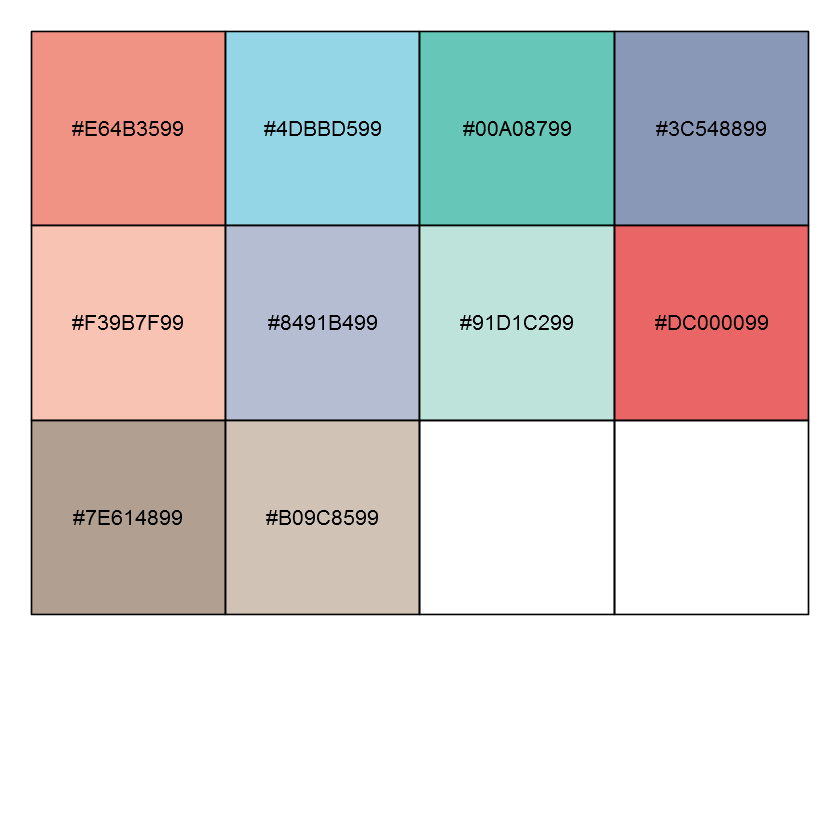

In [7]:
library("scales")
show_col(pal_npg("nrc", alpha = 1)(10))

### Figure 3D overlaped metabolites

In [61]:
nutrition = Overlaped_metabolites_3celllines
nutrition$Metabolites = gsub('\\[\\w\\]','',nutrition$Metabolites)
rownames(nutrition) = nutrition$Metabolites
nutrition.v = nutrition[nutrition$Metabolites != 'o2' & nutrition$Metabolites != 'co2',]

metdata = data.frame(genes = factor(rep(nutrition.v$Metabolites,times = 3),
                                     levels = nutrition.v$Metabolites),
                      MES = c(nutrition.v$effect_MetKO_A549ACE2,
                             nutrition.v$effect_MetKO_Calu3,
                             nutrition.v$effect_MetKO_NHBE),
                     Celltype = factor(rep(c('A549ACE2','Calu3','NHBE'), each = nrow(nutrition.v)),
                                       levels = c('A549ACE2','NHBE','Calu3')),
                     ActionType = c(rep(nutrition.v$Action,times = 3))
                      )
pdf('./modeling/v20200530_cellpaper/figures/Figure 2D_overlapped_metabolites_v20230207.pdf',width = 9, height = 3.2)
ggplot(metdata,aes(x = genes,weight = MES, fill = Celltype))+ geom_bar(position = 'dodge')+ 
          lghplot.addtheme(hjust = 1,size = 14,legend.position = 'top')+scale_fill_npg(alpha = 0.6)+
          theme(legend.text = element_text(size=10,face = 'bold'))+
         #scale_fill_aaas()+ 
       xlab('')+ylab('Metabolite Effective Score(MES)')#+ggtitle('Overlapped metabolites from 3 cell lines')
dev.off()

png 
  2

## nature paper_alpha_mutation

### read data

In [44]:
flux3alpha = file2frame('D:/Work/mgh/covid19/modeling/v20220420_naturepaper/out/PQMM_fluxRxnsMean.txt',row.names = 1)
colnames(flux3alpha) = gsub('nERR','ERR',x = colnames(flux3alpha))
clin.alpha = file2frame('D:/Work/mgh/covid19/modeling/v20220420_naturepaper/E-MTAB-11275.txt')
clin.alpha = clin.alpha[!duplicated(clin.alpha$Comment.ENA_RUN.),]
rownames(clin.alpha) = clin.alpha$Comment.ENA_RUN.
idx = intersect(colnames(flux3alpha),rownames(clin.alpha))
flux3alpha = flux3alpha[,idx]
clin.alpha = clin.alpha[idx,]

flux3.annote.alpha = file2frame('D:/Work/mgh/covid19/modeling/v20200530_cellpaper/out/Recon3_covid19_rxns_geneSymbol_20200530v1.txt',row.names = 1)

idxx = rowMeans(abs(flux3alpha))> 1e-6
flux3alpha = flux3alpha[idxx,]
flux3alpha.log2= as.matrix(log2(abs(flux3alpha)+1e-6))
list[IA,IB] = ismember(rownames(flux3alpha.log2),rownames(flux3.annote.alpha))
flux3.annote.alpha = flux3.annote.alpha[IB,]


### VIC

In [25]:
id = (clin.alpha$Factor.Value.infect. == 'SARS-CoV-2 isolate VIC' |  clin.alpha$Factor.Value.infect. == 'mock') &
      clin.alpha$Factor.Value.time. == 24
flux3alpha.VIC = flux3alpha[,id]
flux3alpha.log2.VIC = flux3alpha.log2[,id]
clin.alpha.VIC = clin.alpha[id,]

In [26]:
theservePathway = c('SARS-Cov-2 proteins','SARS-Cov-2 sense RNA',
                   'SARS-Cov-2 antisense RNA','SARS-Cov-2 lipid',
                   'SARS-Cov-2 cleavage','SARS-Cov-2 biomass')
WDA.covid.VIC = one_line_flux_analysis(flux3alpha.VIC,flux3alpha.log2.VIC[,clin.alpha.VIC$Characteristics.infect. != 'mock'],
                                        flux3alpha.log2.VIC[,clin.alpha.VIC$Characteristics.infect. == 'mock'],
                                        flux3.annote.alpha,'./modeling/v20220420_naturepaper/results/oneline_flux_VIC_v20230209',
                                       reserve.pathway = theservePathway)

[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   124"
[1] "N down-regulated rxns: 397"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"


In [27]:
DEflux3.VIC = file2frame('./modeling/v20220420_naturepaper/results/oneline_flux_VIC_v20230209/DEflux.txt')
rownames(DEflux3.VIC) = DEflux3.VIC$ID

### Figure 3A heatmap All

In [30]:
WDA.covid.A549 = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_A549ACE2/WDA.cen.bootstrap.txt')
WDA.covid.Calu3 = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_Calu3/WDA.cen.bootstrap.txt')
WDA.covid.NHBE = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_NHBE/WDA.cen.bootstrap.txt')


In [31]:
   WDA.covid.VIC = file2frame('./modeling/v20220420_naturepaper/results/oneline_flux_VIC/WDA.cen.bootstrap.txt')
    DE1 = WDA.covid.A549[WDA.covid.A549$fdr < 0.1,]
    DE2 = WDA.covid.Calu3[WDA.covid.Calu3$fdr < 0.1,]
    DE3 = WDA.covid.NHBE[WDA.covid.NHBE$fdr < 0.1,]
    DE4 = WDA.covid.VIC[WDA.covid.VIC$fdr < 0.1,]

    rownames(DE1) = DE1$subsystem
    rownames(DE2) = DE2$subsystem
    rownames(DE3) = DE3$subsystem
    rownames(DE4) = DE4$subsystem

    celltypes = c('A549ACE2','Calu3','NHBE','Alpha_isolate')
    tlist1 = list()
    tlist1[[1]] = as.data.frame(t(DE1$DAscore))
    colnames(tlist1[[1]]) = DE1$subsystem
    tlist1[[2]] = as.data.frame(t(DE2$DAscore))
    colnames(tlist1[[2]]) = DE2$subsystem
    tlist1[[3]] = as.data.frame(t(DE3$DAscore))
    colnames(tlist1[[3]]) = DE3$subsystem
    tlist1[[4]] = as.data.frame(t(DE4$DAscore))
    colnames(tlist1[[4]]) = DE4$subsystem

    names(tlist1) = celltypes
    tmpmatrix = t(data.table::rbindlist(tlist1,fill = T))
    colnames(tmpmatrix) = celltypes
    tmpmatrix[is.na(tmpmatrix)] =0
    
    tlist2 = list()
    tlist2[[1]] = as.data.frame(t(DE1$fdr))
    colnames(tlist2[[1]]) = DE1$subsystem
    tlist2[[2]] = as.data.frame(t(DE2$fdr))
    colnames(tlist2[[2]]) = DE2$subsystem
    tlist2[[3]] = as.data.frame(t(DE3$fdr))
    colnames(tlist2[[3]]) = DE3$subsystem
    tlist2[[4]] = as.data.frame(t(DE4$fdr))
    colnames(tlist2[[4]]) = DE4$subsystem

    names(tlist2) =celltypes
    tmpmatrix2 = t(data.table::rbindlist(tlist2,fill = T))
    colnames(tmpmatrix2) = celltypes
    tmpmatrix2[is.na(tmpmatrix2)] =1
    
    display_matrix = matrix(' ',nrow(tmpmatrix),ncol(tmpmatrix))
    display_matrix[tmpmatrix2 < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix[tmpmatrix2 >= 0.01 & tmpmatrix2 < 0.05] = '*'
    display_matrix[tmpmatrix2 >= 0.001 & tmpmatrix2 < 0.01] = '**'
    display_matrix[tmpmatrix2 < 0.001] = '***'
    
    enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
    consist_ids = abs(rowSums(sign(tmpmatrix[,1:3]))) > 1  
    pheatmap::pheatmap(tmpmatrix[consist_ids,],scale = 'none',cluster_rows = T,fontsize_row = 9,fontsize_col = 9,
                       breaks = enbrks,
                       treeheight_row = 20,treeheight_col = 20,legend = T,
                       display_numbers = display_matrix[consist_ids,],
                  #color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(9),
                       #colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                color=colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                  #file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL.pdf',
                   file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL_consist_3celltypes_mutationv1.pdf',
                  ,height = 5,width = 4.5)

In [ ]:
#mean
WDA.covid.VIC = file2frame('./modeling/v20220420_naturepaper/results/oneline_flux_VIC/WDA.cen.bootstrap.txt')
    DE1 = WDA.covid.A549[WDA.covid.A549$fdr < 0.1,]
    DE2 = WDA.covid.Calu3[WDA.covid.Calu3$fdr < 0.1,]
    DE3 = WDA.covid.NHBE[WDA.covid.NHBE$fdr < 0.1,]
    DE4 = WDA.covid.VIC[WDA.covid.VIC$fdr < 0.1,]

    rownames(DE1) = DE1$subsystem
    rownames(DE2) = DE2$subsystem
    rownames(DE3) = DE3$subsystem
    rownames(DE4) = DE4$subsystem

    celltypes = c('A549ACE2','Calu3','NHBE','Alpha_isolate')
    tlist1 = list()
    tlist1[[1]] = as.data.frame(t(DE1$DAscore))
    colnames(tlist1[[1]]) = DE1$subsystem
    tlist1[[2]] = as.data.frame(t(DE2$DAscore))
    colnames(tlist1[[2]]) = DE2$subsystem
    tlist1[[3]] = as.data.frame(t(DE3$DAscore))
    colnames(tlist1[[3]]) = DE3$subsystem
    tlist1[[4]] = as.data.frame(t(DE4$DAscore))
    colnames(tlist1[[4]]) = DE4$subsystem

    names(tlist1) = celltypes
    tmpmatrix = t(data.table::rbindlist(tlist1,fill = T))
    colnames(tmpmatrix) = celltypes
    tmpmatrix[is.na(tmpmatrix)] =0
    
    tlist2 = list()
    tlist2[[1]] = as.data.frame(t(DE1$fdr))
    colnames(tlist2[[1]]) = DE1$subsystem
    tlist2[[2]] = as.data.frame(t(DE2$fdr))
    colnames(tlist2[[2]]) = DE2$subsystem
    tlist2[[3]] = as.data.frame(t(DE3$fdr))
    colnames(tlist2[[3]]) = DE3$subsystem
    tlist2[[4]] = as.data.frame(t(DE4$fdr))
    colnames(tlist2[[4]]) = DE4$subsystem

    names(tlist2) =celltypes
    tmpmatrix2 = t(data.table::rbindlist(tlist2,fill = T))
    colnames(tmpmatrix2) = celltypes
    tmpmatrix2[is.na(tmpmatrix2)] =1
    
    display_matrix = matrix(' ',nrow(tmpmatrix),ncol(tmpmatrix))
    display_matrix[tmpmatrix2 < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix[tmpmatrix2 >= 0.01 & tmpmatrix2 < 0.05] = '*'
    display_matrix[tmpmatrix2 >= 0.001 & tmpmatrix2 < 0.01] = '**'
    display_matrix[tmpmatrix2 < 0.001] = '***'
    
    enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
    consist_ids = abs(rowSums(sign(tmpmatrix[,1:3]))) > 1  
    x1 = tmpmatrix[consist_ids,]
    xa = cbind(rowMeans(x1[,1:3]),x1[,4]
    pheatmap::pheatmap(tmpmatrix[consist_ids,],scale = 'none',cluster_rows = T,fontsize_row = 9,fontsize_col = 9,
                       breaks = enbrks,
                       treeheight_row = 20,treeheight_col = 20,legend = T,
                       display_numbers = display_matrix[consist_ids,],
                  #color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(9),
                       #colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                color=colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                  #file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL.pdf',
                   file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL_consist_3celltypes_mutationv1.pdf',
                  ,height = 5,width = 4.5)

In [48]:
    x1 = tmpmatrix[consist_ids,]
    xa = cbind(rowMeans(x1[,1:3]),x1[,4])
    colnames(xa) = c('IC19', 'Alpha_isolate')
    x2 = tmpmatrix2[consist_ids,]
    xb = cbind(rowMedians(x2[,1:3]),x2[,4])
    colnames(xb) = c('IC19', 'Alpha_isolate')
    display_matrix1 = matrix(' ',nrow(xa),ncol(xa))
    display_matrix1[xb < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix1[xb >= 0.01 & xb < 0.05] = '*'
    display_matrix1[xb >= 0.001 & xb < 0.01] = '**'
    display_matrix1[xb < 0.001] = '***'
 enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
   id = xa[,1]*xa[,2] >= 0
    pheatmap::pheatmap(xa[id,],scale = 'none',cluster_rows = T,fontsize_row = 9,fontsize_col = 9,
                       breaks = enbrks,
                       treeheight_row = 20,treeheight_col = 20,legend = T,
                       display_numbers = display_matrix1[id,],
                  #color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(9),
                       #colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                color=colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                  #file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL.pdf',
                   file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL_consist_3celltypes_mutationv3.pdf',
                  ,height = 5,width = 4.1)

### Overlaped Target in alpha mutation

In [124]:
Targets

[1] "TYMS"  "DHFR"  "PAICS" "GART"  "ATIC"  "PPAT"  "PFAS"

In [45]:
Targets  = Overlaped_target_3celllines$Target
Target_VIC = file2frame('./modeling/v20220420_naturepaper/results/v20221010/KOgene_covid19_alpha_KO_effect_genes_overlapDEflux.txt')
Target_VIC = get_subterm_gene(Target_VIC,Targets)
Target_VIC

,gene,effect_GeneKO
,<chr>,<dbl>
PAICS,PAICS,-3.73907
GART,GART,-3.73907
ATIC,ATIC,-3.73907
PPAT,PPAT,-3.73907
PFAS,PFAS,-3.73907
TYMS,TYMS,4.75276
DHFR,DHFR,4.94331


### Overlaped Metabolites in alpha mutation

In [46]:
get_subterm_met1 <- function(df, mets){
    out = df[is.element(df$metname,mets),]
    cc = sort.int(abs(out$Effect_afterKO),decreasing = T,index.return = T)$ix
    out = out[cc,]
    idx = !duplicated(out$metname)
    out = out[idx,]
    #out = out[abs(out$Effect_afterKO) >= 3,]
    rownames(out) = out$metname
    cc = sort.int(out$Effect_afterKO,decreasing = T,index.return = T)$ix
    out = out[cc,]
    return(out)
}
Metabolites  = Overlaped_metabolites_3celllines$metname
Metabolites_VIC = file2frame('./modeling/v20220420_naturepaper/results/v20221010/KOmet_covid19_alpha_KO_effect_mets_overlapDEflux.txt')
Metabolites_VIC = get_subterm_met1(Metabolites_VIC,Metabolites)
Metabolites_VIC

,metid,Effect_afterKO,metname,pubchemID,HMDBID,smiles,InchiString
,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
"5,10-Methylenetetrahydrofolate",mlthf[c],4.75276,"5,10-Methylenetetrahydrofolate",439175,,[H]OC1=NC(=NC2=C1N1C([H])([H])N(C3=C([H])C([H])=C(C([H])=C3[H])C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])[C@@]1([H])C([H])([H])N2[H])N([H])[H],"InChI=1/C20H23N7O6/c21-20-24-16-15(18(31)25-20)27-9-26(8-12(27)7-22-16)11-3-1-10(2-4-11)17(30)23-13(19(32)33)5-6-14(28)29/h1-4,12-13H,5-9H2,(H,23,30)(H,28,29)(H,32,33)(H4,21,22,24,25,31)/p-2/t12-,13?/s2"
2-Oxoglutarate,akg[m],3.67189,2-Oxoglutarate,51,HMDB00208,[H]C([H])(C([O-])=O)C([H])([H])C(=O)C([O-])=O,"InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(H,7,8)(H,9,10)/p-2"
(S)-2-[5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxamido]Succinate,25aics[c],-3.73907,(S)-2-[5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxamido]Succinate,160666,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC(C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([O-])=O)=C1N([H])[H],"InChI=1/C13H19N4O12P/c14-10-7(11(22)16-4(13(23)24)1-6(18)19)15-3-17(10)12-9(21)8(20)5(29-12)2-28-30(25,26)27/h3-5,8-9,12,20-21H,1-2,14H2,(H,16,22)(H,18,19)(H,23,24)(H2,25,26,27)/p-4/t4?,5-,8-,9-,12-/s2"
5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole,air[c],-3.73907,5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole,161500,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC([H])=C1N([H])[H],"InChI=1/C8H14N3O7P/c9-5-1-10-3-11(5)8-7(13)6(12)4(18-8)2-17-19(14,15)16/h1,3-4,6-8,12-13H,2,9H2,(H2,14,15,16)/p-2/t4-,6-,7-,8?/s2"
5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxylate,5aizc[c],-3.73907,5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxylate,165388,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC(C([O-])=O)=C1N([H])[H],"InChI=1S/C9H14N3O9P/c10-7-4(9(15)16)11-2-12(7)8-6(14)5(13)3(21-8)1-20-22(17,18)19/h2-3,5-6,8,13-14H,1,10H2,(H,15,16)(H2,17,18,19)/p-3/t3-,5-,6-,8-/m1/s1"
N1-(5-Phospho-D-Ribosyl)Glycinamide,gar[c],-3.73907,N1-(5-Phospho-D-Ribosyl)Glycinamide,160913,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N([H])C(=O)C([H])([H])[N+]([H])([H])[H],"InChI=1/C7H15N2O8P/c8-1-4(10)9-7-6(12)5(11)3(17-7)2-16-18(13,14)15/h3,5-7,11-12H,1-2,8H2,(H,9,10)(H2,13,14,15)/p-1/t3-,5-,6-,7?/s2"
N2-Formyl-N1-(5-Phospho-D-Ribosyl)Glycinamide,fgam[c],-3.73907,N2-Formyl-N1-(5-Phospho-D-Ribosyl)Glycinamide,130805,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N([H])C(=O)C([H])([H])N([H])C([H])=O,"InChI=1/C8H15N2O9P/c11-3-9-1-5(12)10-8-7(14)6(13)4(19-8)2-18-20(15,16)17/h3-4,6-8,13-14H,1-2H2,(H,9,11)(H,10,12)(H2,15,16,17)/p-2/t4-,6-,7-,8?/s2"
5-Phospho-Beta-D-Ribosylamine,pram[c],-3.73907,5-Phospho-Beta-D-Ribosylamine,439905,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])[N+]([H])([H])[H],"InChI=1/C5H12NO7P/c6-5-4(8)3(7)2(13-5)1-12-14(9,10)11/h2-5,7-8H,1,6H2,(H2,9,10,11)/p-1/t2-,3-,4-,5-/s2"
2-(Formamido)-N1-(5-Phospho-D-Ribosyl)Acetamidine,fpram[c],-3.73907,2-(Formamido)-N1-(5-Phospho-D-Ribosyl)Acetamidine,NA,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N([H])C(=[N+]([H])[H])C([H])([H])N([H])C([H])=O,"InChI=1/C8H16N3O8P/c9-5(1-10-3-12)11-8-7(14)6(13)4(19-8)2-18-20(15,16)17/h3-4,6-8,13-14H,1-2H2,(H2,9,11)(H,10,12)(H2,15,16,17)/p-1/t4-,6-,7-,8?/s2"


## v20230118 omicron

### DEflux omicron

In [10]:
flux3omicron = file2frame('D:/Work/mgh/covid19/modeling/v20230118_omicron/out/PQMM_fluxRxnsMean.txt',row.names = 1)

flux3.annote.omicron = file2frame('D:/Work/mgh/covid19/modeling/v20200530_cellpaper/out/Recon3_covid19_rxns_geneSymbol_20200530v1.txt',row.names = 1)

idxx = rowMeans(abs(flux3omicron))> 1e-6
flux3omicron = flux3omicron[idxx,]
flux3omicron.log2= as.matrix(log2(abs(flux3omicron)+1e-6))
list[IA,IB] = ismember(rownames(flux3omicron.log2),rownames(flux3.annote.omicron))
flux3.annote.omicron = flux3.annote.omicron[IB,]


In [11]:
get_element <- function(xx1,n){
    tlen = length(xx1)
    out  = rep('',tlen)
    for(i in 1:tlen){
        out[i] = xx1[[i]][n]
    }
    return(out)
}

In [12]:
tmpnames = colnames(flux3omicron)
tmpnames = gsub('D3.3L','D33L',tmpnames)
xx1 = strsplit(tmpnames,'[._]')
#clin.omicron = colnames
clin.omicron = data.frame(id = tmpnames,stringsAsFactors = F,
                         sampleType = get_element(xx1,1),
                         region = get_element(xx1,2),
                         cellType = get_element(xx1,3),
                         viralType = get_element(xx1,4),
                         timeAfterInfection = get_element(xx1,5),
                         replicate = get_element(xx1,6))

In [13]:
summary_vector(clin.omicron$region)

,Numbers,percentage
,<dbl>,<dbl>
UK4,67,19.71
UK5,90,26.47
UK6,54,15.88
UK7,15,4.41
UK8,96,28.24
NY3,18,5.29


#### UK4

In [53]:
tid = clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK4' & clin.omicron$timeAfterInfection == '24h'
viralType = unique(clin.omicron$viralType[tid])


In [64]:
DA.UK4= list()
for(i in 1:length(viralType)){
    if (viralType[i] == 'Mock'){next;}
    pflux = flux3omicron.log2[,clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK4' 
                         & clin.omicron$timeAfterInfection == '24h' & clin.omicron$viralType == viralType[i]]
    cflux = flux3omicron.log2[,clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK4' 
                         & clin.omicron$timeAfterInfection == '24h' & clin.omicron$viralType == 'Mock']
    outdir = paste0('./modeling/v20230118_omicron/results/oneline_flux_',viralType[i])
    if(!dir.exists(outdir)){
        dir.create(outdir)
    }  
    DA.UK4[[i]] = one_line_flux_analysis(flux3omicron,pflux,cflux,flux3.annote.omicron,
                                          outdir)
    
}

[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   232"
[1] "N down-regulated rxns: 279"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   82"
[1] "N down-regulated rxns: 286"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   290"
[1] "N down-regulated rxns: 356"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   496"
[1] "N down-regulated rxns: 361"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    2"
[1] "N control: 3"
[1] "N up-regulated rxns:   126"
[1] "N down-regulated rxns: 292"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    2"
[1] "N control: 3"
[1] "N up-regulated rxns:   183"
[1] "N down-regulated rxns: 298"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   173"
[1] "N down-regulated rxns: 247"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"


#### UK5

In [65]:
tid = clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK5' & clin.omicron$timeAfterInfection == '24h'
viralType = unique(clin.omicron$viralType[tid])
viralType

[1] "AlphaA"          "AlphaAplusRux"   "AlphaOrf6KO"     "AlphaOrf9bKO"   
 [5] "AlphaWT"         "Beta1"           "Delta2A"         "Delta2AplusRux" 
 [9] "Delta2AplusTPCA" "GammaP1A"        "GammaP1B"        "IC19"           
[13] "Mock"            "PolyIC"          "VIC"

#### UK6

In [66]:
tid = clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK6' & clin.omicron$timeAfterInfection == '24h'
viralType = unique(clin.omicron$viralType[tid])
viralType

[1] "AlphaA"   "DeltaA"   "IC19"     "Mock"     "Omicron1" "VIC"

#### UK8

In [69]:
dim(pflux)

[1] 3756    0

In [32]:
tid = clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK8' & clin.omicron$timeAfterInfection == '24h'
viralType = unique(clin.omicron$viralType[tid])
viralType
theservePathway = c('SARS-Cov-2 proteins','SARS-Cov-2 sense RNA',
                   'SARS-Cov-2 antisense RNA','SARS-Cov-2 lipid',
                   'SARS-Cov-2 cleavage','SARS-Cov-2 biomass')

DA.UK8= list()
for(i in 1:length(viralType)){
    if (viralType[i] == 'Mock'){next;}
    pflux = flux3omicron.log2[,clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK8' 
                         & clin.omicron$timeAfterInfection == '24h' & clin.omicron$viralType == viralType[i]]
    cflux = flux3omicron.log2[,clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK8' 
                         & clin.omicron$timeAfterInfection == '24h' & clin.omicron$viralType == 'Mock']
    outdir = paste0('./modeling/v20230118_omicron/results/UK8/oneline_flux_',viralType[i],'_v20230209')
    if(!dir.exists(outdir)){
        dir.create(outdir)
    }  
    DA.UK8[[i]] = one_line_flux_analysis(flux3omicron,pflux,cflux,flux3.annote.omicron,
                                          outdir,reserve.pathway = theservePathway)
    
}

[1] "Alpha" "BA1"   "BA2"   "BA4"   "BA5"   "Delta" "IC19"  "Mock"

[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   62"
[1] "N down-regulated rxns: 422"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   122"
[1] "N down-regulated rxns: 163"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   128"
[1] "N down-regulated rxns: 185"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   111"
[1] "N down-regulated rxns: 134"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   113"
[1] "N down-regulated rxns: 171"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   170"
[1] "N down-regulated rxns: 299"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"
[1] "Step 1: DEflux and bootstrap"
[1] "N cases:    3"
[1] "N control: 3"
[1] "N up-regulated rxns:   136"
[1] "N down-regulated rxns: 280"
[1] "Step1 Done"
[1] "Step2 pathway analysis"


Warning message:
"Using size for a discrete variable is not advised."Warning message:
"Using size for a discrete variable is not advised."

[1] "Step2 down"


In [33]:
names(DA.UK8) = viralType[1:7]

### Figure heatmap All

In [8]:
WDA.covid.A549 = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_A549ACE2_v20230209/WDA.cen.bootstrap.txt')
WDA.covid.Calu3 = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_Calu3_v20230209/WDA.cen.bootstrap.txt')
WDA.covid.NHBE = file2frame('./modeling/v20200530_cellpaper/results/oneline_flux_NHBE_v20230209/WDA.cen.bootstrap.txt')


In [14]:
tid = clin.omicron$cellType == 'Calu3' & clin.omicron$region == 'UK8' & clin.omicron$timeAfterInfection == '24h'
viralType = unique(clin.omicron$viralType[tid])
viralType

[1] "Alpha" "BA1"   "BA2"   "BA4"   "BA5"   "Delta" "IC19"  "Mock"

In [15]:
DA.UK8= list()
for(i in 1:length(viralType)){
    if (viralType[i] == 'Mock'){next;}
    outdir = paste0('./modeling/v20230118_omicron/results/UK8/oneline_flux_',viralType[i],'_v20230209')
    if(!dir.exists(outdir)){
        dir.create(outdir)
    }  
    DA.UK8[[i]] = file2frame(paste0(outdir,'/','WDA.cen.bootstrap.txt'))
    
}
names(DA.UK8) = viralType[1:7]

In [79]:
WDA.covid.VIC = file2frame('./modeling/v20220420_naturepaper/results/oneline_flux_VIC_v20230209/WDA.cen.bootstrap.txt')
    DE = list()
    DE[[1]] = WDA.covid.A549[WDA.covid.A549$fdr < 1,]
    DE[[2]] = WDA.covid.Calu3[WDA.covid.Calu3$fdr < 1,]
    DE[[3]] = WDA.covid.NHBE[WDA.covid.NHBE$fdr < 1,]
    #DE[[4]] = DA.UK8[['Alpha']][DA.UK8[['Alpha']]$fdr < 1,]
    DE[[4]] = WDA.covid.VIC[WDA.covid.VIC$fdr < 1,]
    DE[[5]] = DA.UK8[['Delta']][DA.UK8[['Delta']]$fdr < 1,]
    DE[[6]] = DA.UK8[['BA1']][DA.UK8[['BA1']]$fdr < 1,]
    DE[[7]] = DA.UK8[['BA2']][DA.UK8[['BA2']]$fdr < 1,]
    DE[[8]] = DA.UK8[['BA4']][DA.UK8[['BA4']]$fdr < 1,]
    DE[[9]] = DA.UK8[['BA5']][DA.UK8[['BA5']]$fdr < 1,]
   for(i in 1:9){
       rownames(DE[[i]]) = DE[[i]]$subsystem
   }


    celltypes = c('A549ACE2','Calu3','NHBE','Alpha','Delta','BA1','BA2','BA4','BA5')
   
    tlist1 = list()
    for(i in 1:9){
        tlist1[[i]] = as.data.frame(t(DE[[i]]$DAscore))
        colnames(tlist1[[i]]) = DE[[i]]$subsystem
        
    }
    names(tlist1) = celltypes
    tmpmatrix = t(data.table::rbindlist(tlist1,fill = T))
    colnames(tmpmatrix) = celltypes
    tmpmatrix[is.na(tmpmatrix)] =0
    
    tlist2 = list()
    for(i in 1:9){
        tlist2[[i]] = as.data.frame(t(DE[[i]]$fdr))
        colnames(tlist2[[i]]) = DE[[i]]$subsystem  
    }
    names(tlist2) =celltypes
    tmpmatrix2 = t(data.table::rbindlist(tlist2,fill = T))
    colnames(tmpmatrix2) = celltypes
    tmpmatrix2[is.na(tmpmatrix2)] =1
    
    display_matrix = matrix(' ',nrow(tmpmatrix),ncol(tmpmatrix))
    display_matrix[tmpmatrix2 < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix[tmpmatrix2 >= 0.01 & tmpmatrix2 < 0.05] = '*'
    display_matrix[tmpmatrix2 >= 0.001 & tmpmatrix2 < 0.01] = '**'
    display_matrix[tmpmatrix2 < 0.001] = '***'
    
    enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
    consist_ids = abs(rowSums(sign(tmpmatrix[,1:3]))) > 1 

In [77]:
rowMedians <- function(x){
    return(apply(x,1,median))
}

In [78]:
x1 = tmpmatrix[consist_ids,]
    xa = cbind(rowMeans(x1[,1:3]),x1[,4:9])
    colnames(xa) = c('IC19', 'Alpha','Delta','BA1','BA2','BA4','BA5')
    x2 = tmpmatrix2[consist_ids,]
    xb = cbind(rowMedians(x2[,1:3]),x2[,4:9])
    colnames(xb) = c('IC19', 'Alpha','Delta','BA1','BA2','BA4','BA5')
    display_matrix1 = matrix(' ',nrow(xa),ncol(xa))
    display_matrix1[xb < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix1[xb >= 0.01 & xb < 0.05] = '*'
    display_matrix1[xb >= 0.001 & xb < 0.01] = '**'
    display_matrix1[xb < 0.001] = '***'
 enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
   id = xa[,1]*xa[,6] >= 0
pheatmap::pheatmap(xa[id,],scale = 'none',cluster_rows = T,cluster_cols = F,fontsize_row = 9,fontsize_col = 9,
                       breaks = enbrks,
                       treeheight_row = 20,treeheight_col = 20,legend = T,
                       display_numbers = display_matrix1[id,],
                  #color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(9),
                       #colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                color=colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                  #file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL.pdf',
                   file ='./modeling/v20230118_omicron/figures/Figure 3A_pathwayheatmap_ALL_consist_3celltypes_mutationv1_allpathwaysAA.pdf',
                  ,height = 5,width = 7)

In [82]:
x1 = tmpmatrix[consist_ids,]
    xa = cbind(rowMeans(x1[,1:3]),x1[,4:5],rowMeans(x1[,6:9]))
    colnames(xa) = c('IC19', 'Alpha','Delta','Omicron')
    x2 = tmpmatrix2[consist_ids,]
    xb = cbind(rowMins(x2[,1:3]),x2[,4:5],rowMeans(x2[,6:9]))
    colnames(xb) = c('IC19', 'Alpha','Delta','Omicron')
    display_matrix1 = matrix(' ',nrow(xa),ncol(xa))
    display_matrix1[xb < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix1[xb >= 0.01 & xb < 0.05] = '*'
    display_matrix1[xb >= 0.001 & xb < 0.01] = '**'
    display_matrix1[xb < 0.001] = '***'
 enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
   id = xa[,1]*xa[,4] >= 0 & xa[,1]*xa[,3] >= 0 & xa[,1]*xa[,2] >=0
pheatmap::pheatmap(xa[id,],scale = 'none',cluster_rows = T,cluster_cols = F,fontsize_row = 9,fontsize_col = 9,
                       breaks = enbrks,
                       treeheight_row = 20,treeheight_col = 20,legend = T,
                       display_numbers = display_matrix1[id,],
                  #color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(9),
                       #colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                #color=colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                   color=colorRampPalette(c('#4DBBD599','gray95','#E64B3599'))(11),#npg style
                  #file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL.pdf',
                   file ='./modeling/v20230118_omicron/figures/Figure 3A_pathwayheatmap_ALL_consist_3celltypes_mutationv1_mean_natureAlpha__v20230209_allpathwaysAA.pdf',
                  ,height = 4,width = 3.5)

In [31]:
rowMins <- function(x){
    return(apply(x,1,min))
}

In [33]:
# + bedrest result
bedrest = file2frame('E:/iHuman/projects/bedrest/results/v20230306/long_Post_vs_Pre/WDA.cen.bootstrap.txt')
rownames(bedrest) = bedrest$subsystem
x1 = tmpmatrix[consist_ids,]
    xa = cbind(rowMeans(x1[,1:3]),x1[,4:5],rowMeans(x1[,6:9]))
    #colnames(xa) = c('IC19', 'Alpha','Delta','Omicron')
    bedrest.common = bedrest[rownames(xa),]
    rownames(bedrest.common) = rownames(xa)
    bedrest.common$DAscore[is.na(bedrest.common$DAscore)] = 0
    bedrest.common[is.na(bedrest.common)] = 1
    xa = cbind(xa,bedrest.common$DAscore)
    colnames(xa) = c('IC19', 'Alpha','Delta','Omicron','Bedrest')


    x2 = tmpmatrix2[consist_ids,]
    xb = cbind(rowMins(x2[,1:3]),x2[,4:5],rowMeans(x2[,6:9]))
    #colnames(xb) = c('IC19', 'Alpha','Delta','Omicron')
    xb = cbind(xb,bedrest.common$fdr)
    colnames(xb) = c('IC19', 'Alpha','Delta','Omicron','Bedrest')


    display_matrix1 = matrix(' ',nrow(xa),ncol(xa))
    display_matrix1[xb < 0.1] = '.'
    #display_matrix[tmpmatrix2 >= 0.05 & tmpmatrix2 < 0.1] = '.'
    display_matrix1[xb >= 0.01 & xb < 0.05] = '*'
    display_matrix1[xb >= 0.001 & xb < 0.01] = '**'
    display_matrix1[xb < 0.001] = '***'
 enbrks<-c(-1,-0.8,-0.4,-0.2,-0.05,-0.02,0.02,0.05,0.2,0.4,0.8,1)
   id = xa[,1]*xa[,4] >= 0 & xa[,1]*xa[,3] >= 0 & xa[,1]*xa[,2] >=0
pheatmap::pheatmap(xa[id,],scale = 'none',cluster_rows = T,cluster_cols = F,fontsize_row = 9,fontsize_col = 9,
                       breaks = enbrks,
                       treeheight_row = 20,treeheight_col = 20,legend = T,
                       display_numbers = display_matrix1[id,],
                  #color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(9),
                       #colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                #color=colorRampPalette(c('#008280','gray95','#BB0021'))(11),
                   color=colorRampPalette(c('#4DBBD599','gray95','#E64B3599'))(11),#npg style
                  #file ='./modeling/v20200530_cellpaper/figures/Figure 3A_pathwayheatmap_ALL.pdf',
                   file ='./modeling/v20230118_omicron/figures/Figure 3A_pathwayheatmap_ALL_consist_3celltypes_mutationv1_mean_natureAlpha__v20230209_bedrest_allpathways.pdf',
                  ,height = 4,width = 3.8)

### overlaped genes and mets

#### deta

In [47]:
Overlaped_target_3celllines$Target

[1] "TYMS"  "DHFR"  "PAICS" "GART"  "ATIC"  "PPAT"  "PFAS"

In [48]:
#genes
Targets  = Overlaped_target_3celllines$Target
Target_Deta = file2frame('./modeling/v20230118_omicron/results/UK8/KOgene_covid19_Delta_KO_effect_genes.txt')
Target_Deta = get_subterm_gene(Target_Deta,Targets)
Target_Deta

,gene,effect_GeneKO
,<chr>,<dbl>
PAICS,PAICS,-5.09039
GART,GART,-5.09039
ATIC,ATIC,-5.09039
PPAT,PPAT,-5.09039
PFAS,PFAS,-5.09039
TYMS,TYMS,4.57283
DHFR,DHFR,8.90712


In [49]:
# metabolites
get_subterm_met1 <- function(df, mets){
    out = df[is.element(df$metname,mets),]
    cc = sort.int(abs(out$Effect_afterKO),decreasing = T,index.return = T)$ix
    out = out[cc,]
    idx = !duplicated(out$metname)
    out = out[idx,]
    #out = out[abs(out$Effect_afterKO) >= 3,]
    rownames(out) = out$metname
    cc = sort.int(out$Effect_afterKO,decreasing = T,index.return = T)$ix
    out = out[cc,]
    return(out)
}
Metabolites  = Overlaped_metabolites_3celllines$metname
Metabolites_Deta = file2frame('./modeling/v20230118_omicron/results/UK8/KOmet_covid19_Delta_KO_effect_mets.txt')
Metabolites_Deta = get_subterm_met1(Metabolites_Deta,Metabolites)
Metabolites_Deta

,metid,Effect_afterKO,metname,pubchemID,HMDBID,smiles,InchiString
,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
"5,10-Methylenetetrahydrofolate",mlthf[c],4.57283,"5,10-Methylenetetrahydrofolate",439175,,[H]OC1=NC(=NC2=C1N1C([H])([H])N(C3=C([H])C([H])=C(C([H])=C3[H])C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])[C@@]1([H])C([H])([H])N2[H])N([H])[H],"InChI=1/C20H23N7O6/c21-20-24-16-15(18(31)25-20)27-9-26(8-12(27)7-22-16)11-3-1-10(2-4-11)17(30)23-13(19(32)33)5-6-14(28)29/h1-4,12-13H,5-9H2,(H,23,30)(H,28,29)(H,32,33)(H4,21,22,24,25,31)/p-2/t12-,13?/s2"
2-Oxoglutarate,akg[m],4.27547,2-Oxoglutarate,51,HMDB00208,[H]C([H])(C([O-])=O)C([H])([H])C(=O)C([O-])=O,"InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(H,7,8)(H,9,10)/p-2"
L-Phenylalanine,phe_L[c],-5.00000,L-Phenylalanine,6140,HMDB00159,[H]C1=C([H])C([H])=C(C([H])=C1[H])C([H])([H])[C@@]([H])(C([O-])=O)[N+]([H])([H])[H],"InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-7/h1-5,8H,6,10H2,(H,11,12)/t8-/m0/s1"
(S)-2-[5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxamido]Succinate,25aics[c],-5.09039,(S)-2-[5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxamido]Succinate,160666,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC(C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([O-])=O)=C1N([H])[H],"InChI=1/C13H19N4O12P/c14-10-7(11(22)16-4(13(23)24)1-6(18)19)15-3-17(10)12-9(21)8(20)5(29-12)2-28-30(25,26)27/h3-5,8-9,12,20-21H,1-2,14H2,(H,16,22)(H,18,19)(H,23,24)(H2,25,26,27)/p-4/t4?,5-,8-,9-,12-/s2"
5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole,air[c],-5.09039,5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole,161500,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC([H])=C1N([H])[H],"InChI=1/C8H14N3O7P/c9-5-1-10-3-11(5)8-7(13)6(12)4(18-8)2-17-19(14,15)16/h1,3-4,6-8,12-13H,2,9H2,(H2,14,15,16)/p-2/t4-,6-,7-,8?/s2"
5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxylate,5aizc[c],-5.09039,5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxylate,165388,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC(C([O-])=O)=C1N([H])[H],"InChI=1S/C9H14N3O9P/c10-7-4(9(15)16)11-2-12(7)8-6(14)5(13)3(21-8)1-20-22(17,18)19/h2-3,5-6,8,13-14H,1,10H2,(H,15,16)(H2,17,18,19)/p-3/t3-,5-,6-,8-/m1/s1"
N1-(5-Phospho-D-Ribosyl)Glycinamide,gar[c],-5.09039,N1-(5-Phospho-D-Ribosyl)Glycinamide,160913,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N([H])C(=O)C([H])([H])[N+]([H])([H])[H],"InChI=1/C7H15N2O8P/c8-1-4(10)9-7-6(12)5(11)3(17-7)2-16-18(13,14)15/h3,5-7,11-12H,1-2,8H2,(H,9,10)(H2,13,14,15)/p-1/t3-,5-,6-,7?/s2"
N2-Formyl-N1-(5-Phospho-D-Ribosyl)Glycinamide,fgam[c],-5.09039,N2-Formyl-N1-(5-Phospho-D-Ribosyl)Glycinamide,130805,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N([H])C(=O)C([H])([H])N([H])C([H])=O,"InChI=1/C8H15N2O9P/c11-3-9-1-5(12)10-8-7(14)6(13)4(19-8)2-18-20(15,16)17/h3-4,6-8,13-14H,1-2H2,(H,9,11)(H,10,12)(H2,15,16,17)/p-2/t4-,6-,7-,8?/s2"
5-Phospho-Beta-D-Ribosylamine,pram[c],-5.09039,5-Phospho-Beta-D-Ribosylamine,439905,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])[N+]([H])([H])[H],"InChI=1/C5H12NO7P/c6-5-4(8)3(7)2(13-5)1-12-14(9,10)11/h2-5,7-8H,1,6H2,(H2,9,10,11)/p-1/t2-,3-,4-,5-/s2"


#### omicron

In [50]:
#genes
Targets  = Overlaped_target_3celllines$Target
Target_Omicron = file2frame('./modeling/v20230118_omicron/results/UK8/KOgene_covid19_omicron_KO_effect_genes.txt')
Target_Omicron = get_subterm_gene(Target_Omicron,Targets)
Target_Omicron

,gene,effect_GeneKO
,<chr>,<dbl>
PAICS,PAICS,-4.9911
GART,GART,-4.9911
ATIC,ATIC,-4.9911
PPAT,PPAT,-4.9911
PFAS,PFAS,-4.9911


In [39]:
# metabolites
get_subterm_met1 <- function(df, mets){
    out = df[is.element(df$metname,mets),]
    cc = sort.int(abs(out$Effect_afterKO),decreasing = T,index.return = T)$ix
    out = out[cc,]
    idx = !duplicated(out$metname)
    out = out[idx,]
    #out = out[abs(out$Effect_afterKO) >= 3,]
    rownames(out) = out$metname
    cc = sort.int(out$Effect_afterKO,decreasing = T,index.return = T)$ix
    out = out[cc,]
    return(out)
}
Metabolites  = Overlaped_metabolites_3celllines$metname
Metabolites_Omicron = file2frame('./modeling/v20230118_omicron/results/UK8/KOmet_covid19_omicron_KO_effect_mets.txt')
Metabolites_Omicron = get_subterm_met1(Metabolites_Omicron,Metabolites)
Metabolites_Omicron

,metid,Effect_afterKO,metname,pubchemID,HMDBID,smiles,InchiString
,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
2-Oxoglutarate,akg[c],2.18592,2-Oxoglutarate,51,HMDB00208,[H]C([H])(C([O-])=O)C([H])([H])C(=O)C([O-])=O,"InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(H,7,8)(H,9,10)/p-2"
"5,10-Methylenetetrahydrofolate",mlthf[c],0.00000,"5,10-Methylenetetrahydrofolate",439175,,[H]OC1=NC(=NC2=C1N1C([H])([H])N(C3=C([H])C([H])=C(C([H])=C3[H])C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])[C@@]1([H])C([H])([H])N2[H])N([H])[H],"InChI=1/C20H23N7O6/c21-20-24-16-15(18(31)25-20)27-9-26(8-12(27)7-22-16)11-3-1-10(2-4-11)17(30)23-13(19(32)33)5-6-14(28)29/h1-4,12-13H,5-9H2,(H,23,30)(H,28,29)(H,32,33)(H4,21,22,24,25,31)/p-2/t12-,13?/s2"
L-Phenylalanine,phe_L[c],-3.85863,L-Phenylalanine,6140,HMDB00159,[H]C1=C([H])C([H])=C(C([H])=C1[H])C([H])([H])[C@@]([H])(C([O-])=O)[N+]([H])([H])[H],"InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-7/h1-5,8H,6,10H2,(H,11,12)/t8-/m0/s1"
(S)-2-[5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxamido]Succinate,25aics[c],-4.99108,(S)-2-[5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxamido]Succinate,160666,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC(C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([O-])=O)=C1N([H])[H],"InChI=1/C13H19N4O12P/c14-10-7(11(22)16-4(13(23)24)1-6(18)19)15-3-17(10)12-9(21)8(20)5(29-12)2-28-30(25,26)27/h3-5,8-9,12,20-21H,1-2,14H2,(H,16,22)(H,18,19)(H,23,24)(H2,25,26,27)/p-4/t4?,5-,8-,9-,12-/s2"
5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole,air[c],-4.99108,5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole,161500,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC([H])=C1N([H])[H],"InChI=1/C8H14N3O7P/c9-5-1-10-3-11(5)8-7(13)6(12)4(18-8)2-17-19(14,15)16/h1,3-4,6-8,12-13H,2,9H2,(H2,14,15,16)/p-2/t4-,6-,7-,8?/s2"
5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxylate,5aizc[c],-4.99108,5-Amino-1-(5-Phospho-D-Ribosyl)Imidazole-4-Carboxylate,165388,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N1C([H])=NC(C([O-])=O)=C1N([H])[H],"InChI=1S/C9H14N3O9P/c10-7-4(9(15)16)11-2-12(7)8-6(14)5(13)3(21-8)1-20-22(17,18)19/h2-3,5-6,8,13-14H,1,10H2,(H,15,16)(H2,17,18,19)/p-3/t3-,5-,6-,8-/m1/s1"
N1-(5-Phospho-D-Ribosyl)Glycinamide,gar[c],-4.99108,N1-(5-Phospho-D-Ribosyl)Glycinamide,160913,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N([H])C(=O)C([H])([H])[N+]([H])([H])[H],"InChI=1/C7H15N2O8P/c8-1-4(10)9-7-6(12)5(11)3(17-7)2-16-18(13,14)15/h3,5-7,11-12H,1-2,8H2,(H,9,10)(H2,13,14,15)/p-1/t3-,5-,6-,7?/s2"
N2-Formyl-N1-(5-Phospho-D-Ribosyl)Glycinamide,fgam[c],-4.99108,N2-Formyl-N1-(5-Phospho-D-Ribosyl)Glycinamide,130805,,[H]O[C@@]1([H])C([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])N([H])C(=O)C([H])([H])N([H])C([H])=O,"InChI=1/C8H15N2O9P/c11-3-9-1-5(12)10-8-7(14)6(13)4(19-8)2-18-20(15,16)17/h3-4,6-8,13-14H,1-2H2,(H,9,11)(H,10,12)(H2,15,16,17)/p-2/t4-,6-,7-,8?/s2"
5-Phospho-Beta-D-Ribosylamine,pram[c],-4.99108,5-Phospho-Beta-D-Ribosylamine,439905,,[H]O[C@@]1([H])[C@@]([H])(O[C@]([H])(C([H])([H])OP([O-])([O-])=O)[C@@]1([H])O[H])[N+]([H])([H])[H],"InChI=1/C5H12NO7P/c6-5-4(8)3(7)2(13-5)1-12-14(9,10)11/h2-5,7-8H,1,6H2,(H2,9,10,11)/p-1/t2-,3-,4-,5-/s2"


### Figure 3C and 3D genes and mets in mutation

In [55]:
# Figure 3C targets
tgenes = Overlaped_target_3celllines$Target
genedataAll = data.frame(genes = factor(rep(tgenes,times = 4),
                                     levels = tgenes),
                      GES = c(Overlaped_target_3celllines$effect_GeneKO_Calu3,
                             Target_VIC[tgenes,]$effect_GeneKO,
                             Target_Deta[tgenes,]$effect_GeneKO,
                             Target_Omicron[tgenes,]$effect_GeneKO),
                     Isolate = factor(rep(c('IC19','Alpha','Deta','Omicron'), each = length(tgenes)),
                                       levels = c('IC19','Alpha','Deta','Omicron')),
                     ActionType = c(rep(Overlaped_target_3celllines$Action,times = 4))
                      )
pdf('./modeling/v20230118_omicron/figures/Figure 3C_target_genes_all_isolate_v20230209.pdf',width = 5.3, height = 3)
ggplot(genedataAll,aes(x = genes,weight = GES, fill = Isolate))+ geom_bar(position = 'dodge')+ 
          lghplot.addtheme(hjust = 1,size = 14,legend.position = 'top')+scale_fill_npg(alpha = 0.6)+
          theme(legend.text = element_text(size=10,face = 'bold'))+ xlab('')+
          ylab('Gene Effective Score(GES)')#+ggtitle('Overlapped targets from 3 cell lines')
dev.off()

png 
  2

In [71]:
nutrition = Overlaped_metabolites_3celllines
nutrition$Metabolites = gsub('\\[\\w\\]','',nutrition$Metabolites)
rownames(nutrition) = nutrition$Metabolites
nutrition.v = nutrition[nutrition$Metabolites != 'o2' & nutrition$Metabolites != 'co2',]

In [56]:
#prepare data
#IC19
nutrition = Overlaped_metabolites_3celllines
nutrition$Metabolites = gsub('\\[\\w\\]','',nutrition$Metabolites)
rownames(nutrition) = nutrition$Metabolites
nutrition.v = nutrition[nutrition$Metabolites != 'o2' & nutrition$Metabolites != 'co2',]

# alpha
nutrition_VIC = Metabolites_VIC
nutrition_VIC$Metabolites = gsub('\\[\\w\\]','',nutrition_VIC$metid)
rownames(nutrition_VIC) = nutrition_VIC$Metabolites
nutrition_VIC.v = nutrition_VIC[nutrition_VIC$Metabolites != 'o2' & nutrition_VIC$Metabolites != 'co2',]

# deta
nutrition_Deta = Metabolites_Deta
nutrition_Deta$Metabolites = gsub('\\[\\w\\]','',nutrition_Deta$metid)
rownames(nutrition_Deta) = nutrition_Deta$Metabolites
nutrition_Deta.v = nutrition_Deta[nutrition_Deta$Metabolites != 'o2' & nutrition_Deta$Metabolites != 'co2',]

# omicron
nutrition_Omicron = Metabolites_Omicron
nutrition_Omicron$Metabolites = gsub('\\[\\w\\]','',nutrition_Omicron$metid)
rownames(nutrition_Omicron) = nutrition_Omicron$Metabolites
nutrition_Omicron.v = nutrition_Omicron[nutrition_Omicron$Metabolites != 'o2' & nutrition_Omicron$Metabolites != 'co2',]


tmets = nutrition.v$Metabolites

metdataALL = data.frame(genes = factor(rep(nutrition.v$Metabolites,times = 4),
                                     levels = nutrition.v$Metabolites),
                      MES = c(nutrition.v[tmets,]$effect_MetKO_Calu3,
                              nutrition_VIC.v[tmets,]$Effect_afterKO,
                              nutrition_Deta.v[tmets,]$Effect_afterKO,
                              nutrition_Omicron.v[tmets,]$Effect_afterKO),
                     Isolate = factor(rep(c('IC19','Alpha','Deta','Omicron'), each = nrow(nutrition.v)),
                                       levels = c('IC19','Alpha','Deta','Omicron')),
                     ActionType = c(rep(nutrition.v$Action,times = 4))
                      )
pdf('./modeling/v20230118_omicron/figures/Figure 3D_overlapped_metabolites__all_isolate_v20230209.pdf',width = 9.5, height = 3.2)
ggplot(metdataALL,aes(x = genes,weight = MES, fill = Isolate))+ geom_bar(position = 'dodge')+ 
          lghplot.addtheme(hjust = 1,size = 14,legend.position = 'top')+scale_fill_npg(alpha = 0.6)+
          theme(legend.text = element_text(size=10,face = 'bold'))+ xlab('')+
           ylab('Metabolite Effective Score(MES)')#+ggtitle('Overlapped metabolites from 3 cell lines')
dev.off()

png 
  2